## 层和块

层的步骤都可以分为三步：1.接受一组输入 2.生成相应输出 3.由一组可调整的参数描述  
块（block）可以描述单个层、由多个层组成的组件或整个模型本身
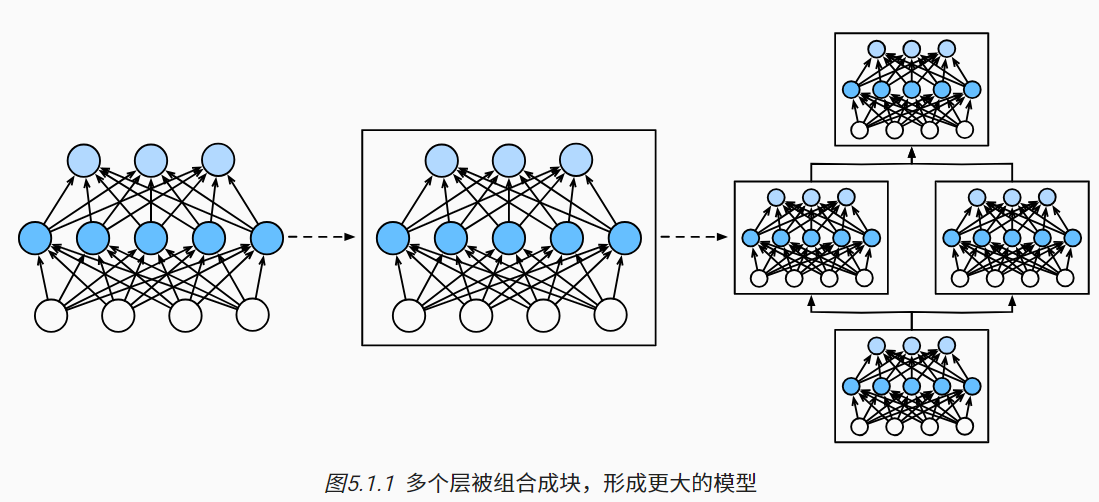

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-0.0226,  0.0149,  0.0526, -0.1418, -0.0551, -0.0623,  0.0453, -0.0480,
          0.0164, -0.1097],
        [ 0.0040,  0.0141, -0.0121, -0.0416,  0.0529, -0.1142, -0.0510, -0.1516,
         -0.0593, -0.1453]], grad_fn=<AddmmBackward0>)

### 自定义块
每个块必须提供的功能：  
1.将输入数据作为其前向传播函数的参数。  
2.通过前向传播函数来生成输出。请注意，输出的形状可能与输入的形状不同。例如，我们上面模型中的第一个全连接的层接收一个20维的输入，但是返回一个维度为256的输出。   
3.计算其输出关于输入的梯度，可通过其反向传播函数进行访问。通常这是自动发生的。  
4.存储和访问前向传播计算所需的参数。
5.根据需要初始化模型参数。  

In [2]:
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):         #   构造函数
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))
net = MLP()
net(X)

tensor([[ 0.0427,  0.0436, -0.0945,  0.0878,  0.0932, -0.0686,  0.2092,  0.1536,
         -0.0536, -0.0517],
        [ 0.0315,  0.1049, -0.2753,  0.2802,  0.1230, -0.0276,  0.3563,  0.0467,
         -0.0156, -0.1299]], grad_fn=<AddmmBackward0>)

### 顺序块


In [3]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里，module是Module子类的一个实例。我们把它保存在'Module'类的成员
            # 变量_modules中。_module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.1276, -0.0677,  0.2550, -0.2023,  0.0674,  0.0589, -0.0199, -0.0831,
         -0.0665,  0.0072],
        [-0.1191,  0.0065,  0.1637, -0.0489,  0.0087,  0.0652, -0.0763, -0.2256,
         -0.2218, -0.0901]], grad_fn=<AddmmBackward0>)

### 小结
1.一个块可以由许多层组成；一个块可以由许多块组成。

2.块可以包含代码。

3.块负责大量的内部处理，包括参数初始化和反向传播。

4.层和块的顺序连接由Sequential块处理。

## 参数管理

In [4]:
#   具有单隐藏层的多层感知机
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.0581],
        [-0.0785]], grad_fn=<AddmmBackward0>)

In [7]:
#   模型参数访问
print(net[2].state_dict())

OrderedDict([('weight', tensor([[ 0.2826,  0.0245, -0.1976, -0.1935,  0.0594, -0.0866, -0.1024, -0.2059]])), ('bias', tensor([0.0129]))])


In [8]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)
net[2].weight.grad == None          #   访问每个参数的梯度

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.0129], requires_grad=True)
tensor([0.0129])


True

### 参数初始化
默认情况下，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵， 这个范围是根据输入和输出维度计算出的。 PyTorch的nn.init模块提供了多种预置初始化方法。

In [9]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([4.3105e-03, 1.0151e-02, 3.9964e-05, 6.5309e-03]), tensor(0.))

In [10]:
import torch
import torch.nn.functional as F
from torch import nn


class withnopara(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X-X.mean()
    
layer=withnopara()
layer(torch.FloatTensor([1,2,3,4,5]))

tensor([-2., -1.,  0.,  1.,  2.])

### 读写文件

#### 加载和保存张量

In [11]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')         #   保存数据

In [12]:
x2 = torch.load('x-file')           #   读取数据
x2

tensor([0, 1, 2, 3])

In [14]:
#   存储一个张量列表
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [15]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

### 加载与保存模型参数
我们保存的是模型的参数而不是整个模型，为了恢复模型，我们需要用代码生成架构，再从磁盘加载参数

In [16]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

In [17]:
#   将模型参数保存
torch.save(net.state_dict(), 'mlp.params')

In [18]:
#   为了恢复模型，需要相同架构
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [20]:
#   由于两个模型参数相同，所以输出也结果相同
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## GPU
在PyTorch中，每个数组都有一个设备（device）， 我们通常将其称为环境（context）

In [23]:
#   查看显卡信息
!nvidia-smi             

Tue Jun 13 17:16:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.37       Driver Version: 527.37       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8     6W /  N/A |    226MiB /  6144MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

默认情况下，张量是在内存中创建的，然后使用CPU计算它。
在PyTorch中，CPU和GPU可以用torch.device('cpu') 和torch.device('cuda')表示。 应该注意的是，cpu设备意味着所有物理CPU和内存， 这意味着PyTorch的计算将尝试使用所有CPU核心。 然而，gpu设备只代表一个卡和相应的显存。 如果有多个GPU，我们使用torch.device(f'cuda:{i}') 来表示第块GPU（从0开始）。 另外，cuda:0和cuda是等价的。

In [24]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

In [26]:
torch.cuda.device_count()       #   查询GPU数量

1

In [27]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

### 张量与GPU

In [28]:
#   查询张量所在设备
#   无论何时我们要对多个项进行操作， 它们都必须在同一个设备上。
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

In [29]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

### 神经网络与GPU

In [31]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())          #   模型参数放到GPU上

In [32]:
net(X)

tensor([[0.3430],
        [0.3430]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [33]:
net[0].weight.data.device

device(type='cuda', index=0)

小结：  
我们可以指定用于存储和计算的设备，例如CPU或GPU。默认情况下，数据在主内存中创建，然后使用CPU进行计算。

深度学习框架要求计算的所有输入数据都在同一设备上，无论是CPU还是GPU。

不经意地移动数据可能会显著降低性能。一个典型的错误如下：计算GPU上每个小批量的损失，并在命令行中将其报告给用户（或将其记录在NumPy ndarray中）时，将触发全局解释器锁，从而使所有GPU阻塞。最好是为GPU内部的日志分配内存，并且只移动较大的日志。

In [47]:
import time
import torch

def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

startTime1=time.time()
for i in range(100):
    A = torch.ones(500,500)
    B = torch.ones(500,500)
    C = torch.matmul(A,B)           #   tensor乘法
endTime1=time.time()

startTime2=time.time()
for i in range(100):
    A = torch.ones(500,500,device=try_gpu())
    B = torch.ones(500,500,device=try_gpu())
    C = torch.matmul(A,B)
endTime2=time.time()

print('cpu计算总时长:', round((endTime1 - startTime1)*1000, 2),'ms')
print('gpu计算总时长:', round((endTime2 - startTime2)*1000, 2),'ms')

cpu计算总时长: 1380.31 ms
gpu计算总时长: 314.59 ms
